In [1]:
%pylab inline

import scipy.ndimage as ndi
from scipy.signal import fftconvolve

%load_ext autoreload
%autoreload 2
from pyotf.otf import SheppardPSF, HanserPSF
from pyotf.utils import easy_fft, easy_ifft
import dphplotting as dplt
from dphutils import bin_ndarray

Populating the interactive namespace from numpy and matplotlib


In [2]:
plt.set_cmap("inferno");

<Figure size 432x288 with 0 Axes>

## Point Scanning

In [3]:
# We'll use a 1.27 NA water dipping objective imaging in water
psf_params = dict(
    na=1.27,
    ni=1.33,
    wl=0.561,
    size=128,
    vec_corr="none"
)

# Set the Nyquist sampling rate
nyquist_sampling = psf_params["wl"] / psf_params["na"] / 4

# our oversampling factor, must be odd for easy integration (for peaked symmetrical funtions the kernel must be odd)
oversample_factor = 3

# we need to be at half nyquist because, for the perfect confocal/airyscan/ISM, we'll get a factor of 2 improvement in OTF cutoff
psf_params["res"] = nyquist_sampling / oversample_factor / 2
psf_params["size"] *= oversample_factor

In [4]:
# plot function 😬
def easy_plot(psfs, labels, psf_params):
    assert len(psfs) == len(labels), "Lengths mismatched"
    assert len(psfs) < 10
    
    fig = plt.figure(None, (3.0 * len(psfs), 6.0), dpi=150)
    fig2, axp = plt.subplots()
    
    base_loc = 200 + len(psfs) * 10 + 1
    
    for (i, p), l in zip(enumerate(psfs), labels):
        fig, grid = dplt.psf_plot(
            p,
            psf_params["na"],
            psf_params["ni"],
            psf_params["ni"],
            psf_params["res"],
            psf_params["res"],
            norm = mpl.colors.PowerNorm(0.3),
            interpolation='bicubic',
            fig=fig,
            loc=base_loc + i
        )
        ax = grid[1]
        ax.text(-0.25, 1.25, l, ha='center', va='bottom', transform=ax.transAxes)

        fig, grid = dplt.otf_plot(
            abs(easy_fft(bin_ndarray(p, bin_size=oversample_factor))),
            psf_params["na"],
            psf_params["wl"],
            psf_params["ni"],
            psf_params["ni"],
            psf_params["res"] * oversample_factor,
            psf_params["res"] * oversample_factor,
            norm = mpl.colors.PowerNorm(0.3),
            interpolation='bicubic',
            fig=fig,
            loc=base_loc + i + len(psfs)
        )
        c = (len(p) + 1) // 2
        pp = p[:, c, c]
        axp.plot((np.arange(len(pp)) - (len(pp) + 1) // 2) * psf_params["res"], pp / pp.max(), label=l)
    axp.yaxis.set_major_locator(plt.NullLocator())
    axp.set_xlabel("Axial Position (µm)")
    axp.set_title("On Axis Intensity")
    axp.legend()
    fig.tight_layout()

In [5]:
# calculate 3D
psf_exc = SheppardPSF(**psf_params).PSFi
psf_params["wl"] = 0.585
psf_det = SheppardPSF(**psf_params).PSFi

In [6]:
# total PSF is multiplication of excitation and emission
psf_con = psf_exc * psf_det

/Users/david/miniconda3/envs/sandbox/lib/python3.6/site-packages/ipykernel_launcher.py:47: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


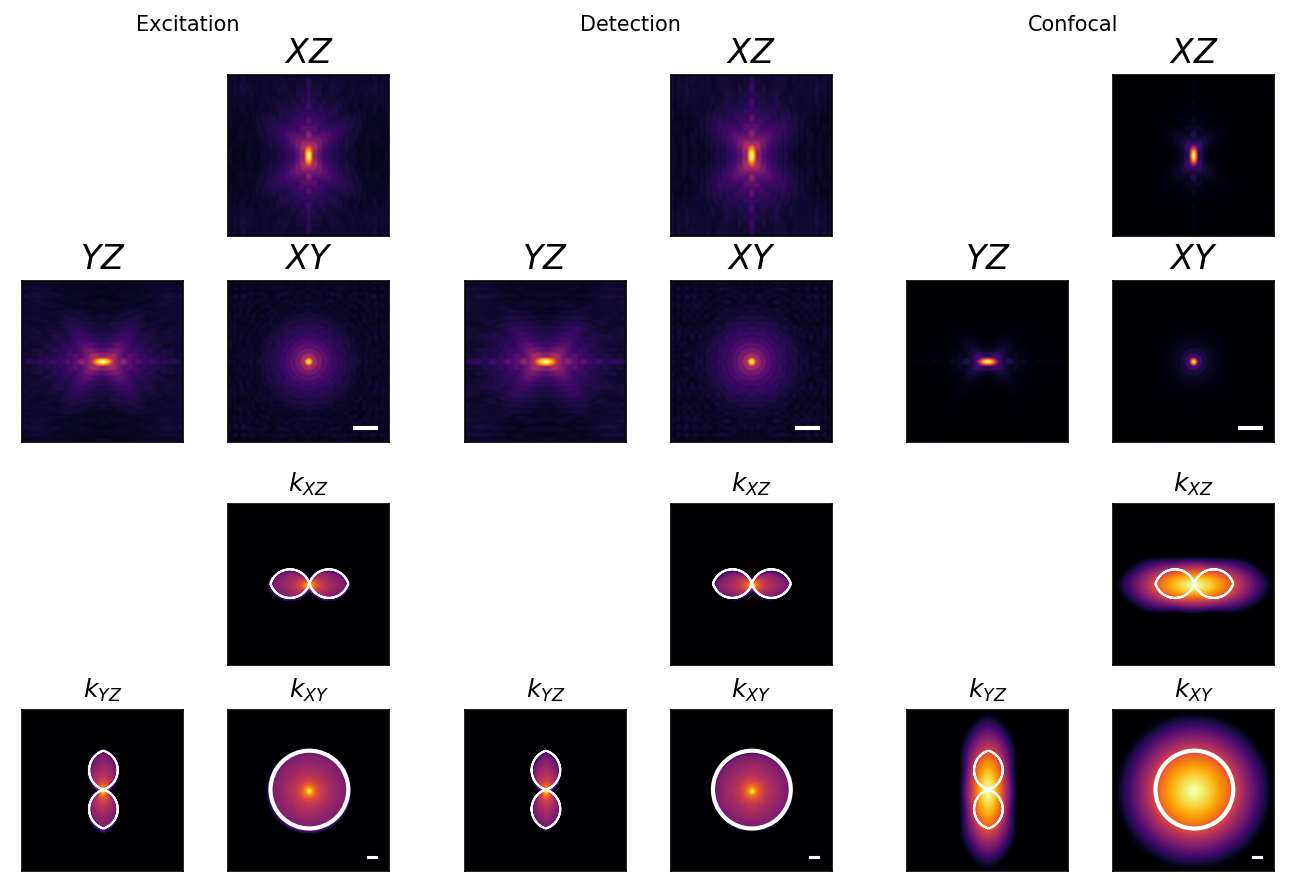

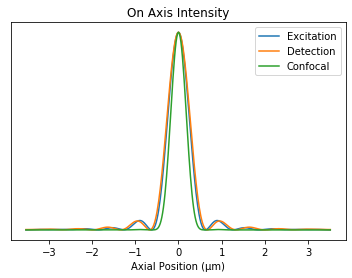

In [7]:
labels = "Excitation", "Detection", "Confocal"
psfs = psf_exc, psf_det, psf_con
easy_plot(psfs, labels, psf_params)

### Different pinhole sizes

When speaking about confocal pinholes we usual work in what's called _Airy Units_ or _AU_. One AU is equivalent to the diamter of the first airy ring, which is defined as the first minimum in the airy function. That means that

$$
AU = 1.22 \frac{\lambda}{NA}
$$

Modeling the effects of the pinhole are actually quite simple: we just need to convolve the detection PSF in the lateral plane with the pinhole transmission function, which in the simplest (and most reasonable case) is simply a ciruclar top hat function. Why convolution? If you were to image a single point emitter perfectly aligned with the excitation PSF then you'd just multiply by the pinhole and integrate. But what if your emitter is off-axis? Then it's image is also off axis etc.

In [8]:
# define airy units in terms of pixels
airy_unit = 1.22 * psf_params["wl"] / psf_params["na"] / psf_params["res"]
airy_unit

30.53262032085561

In [9]:
def disk_kernel(radius):
    full_size = int(np.ceil(radius * 2))
    if full_size % 2 == 0:
        full_size += 1
    coords = np.indices((full_size, full_size)) - (full_size - 1) // 2
    r = np.sqrt((coords**2).sum(0))
    kernel = r < radius
    return kernel / kernel.sum()

In [10]:
kernel = disk_kernel(1 * airy_unit / 2)
psf_det_au1 = fftconvolve(psf_det, kernel[None], "same", axes=(1,2))
psf_con_au1 = psf_det_au1 * psf_exc

/Users/david/miniconda3/envs/sandbox/lib/python3.6/site-packages/ipykernel_launcher.py:47: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


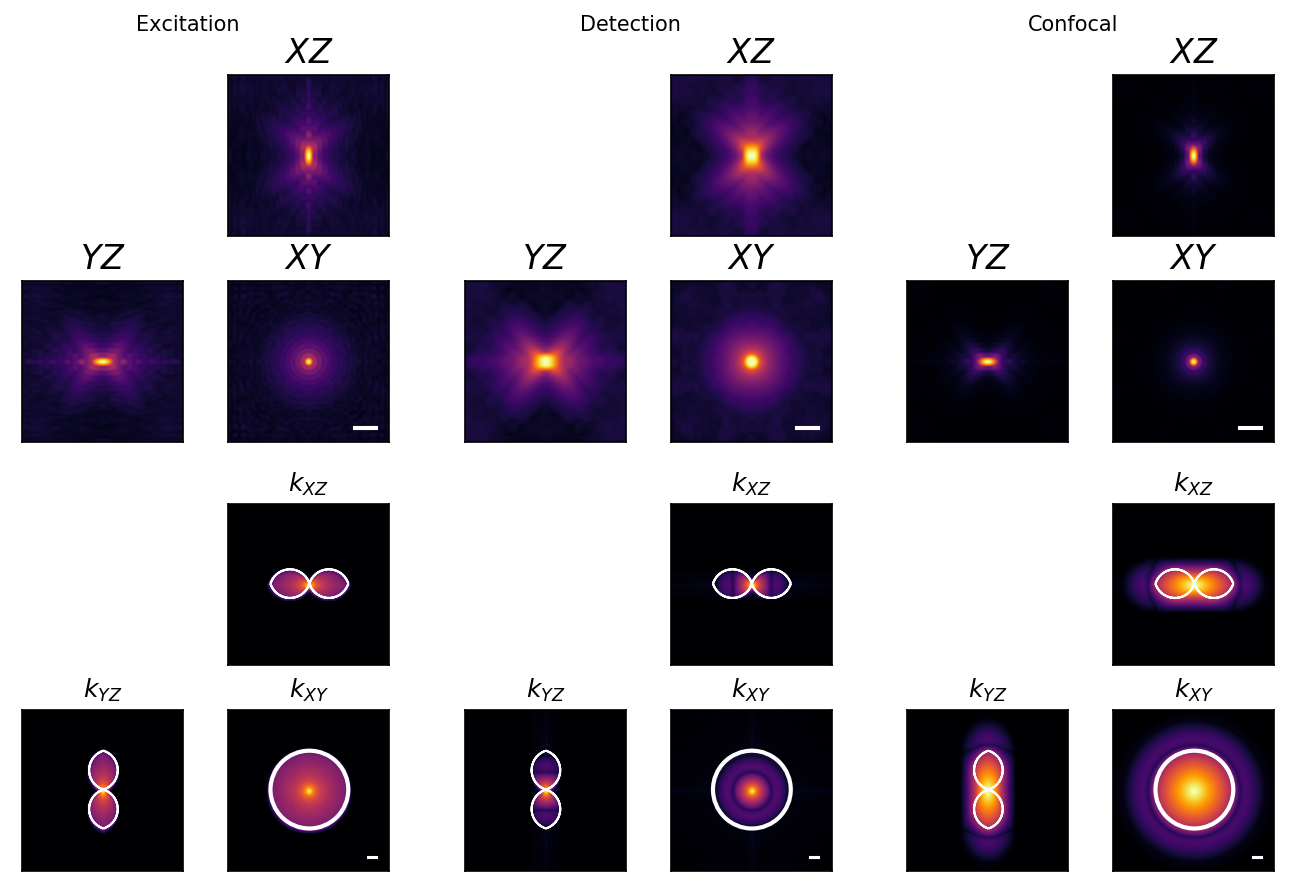

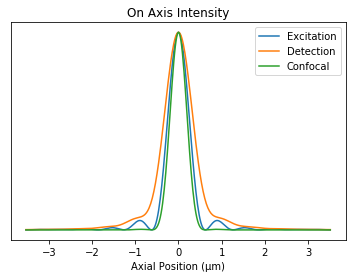

In [11]:
easy_plot((psf_exc, psf_det_au1, psf_con_au1), labels, psf_params)

In [12]:
# now lets try 10 AU, 1 AU and 0.1 AU
psf_au = []
label_au = []
for au in (0.1, 1, 10):
    
    kernel = disk_kernel(au * airy_unit / 2)
    psf_det_au = fftconvolve(psf_det, kernel[None], "same", axes=(1,2))
    
    psf_au.append(psf_det_au * psf_exc)
    label_au.append(f"{au:} AU")    

/Users/david/miniconda3/envs/sandbox/lib/python3.6/site-packages/ipykernel_launcher.py:47: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


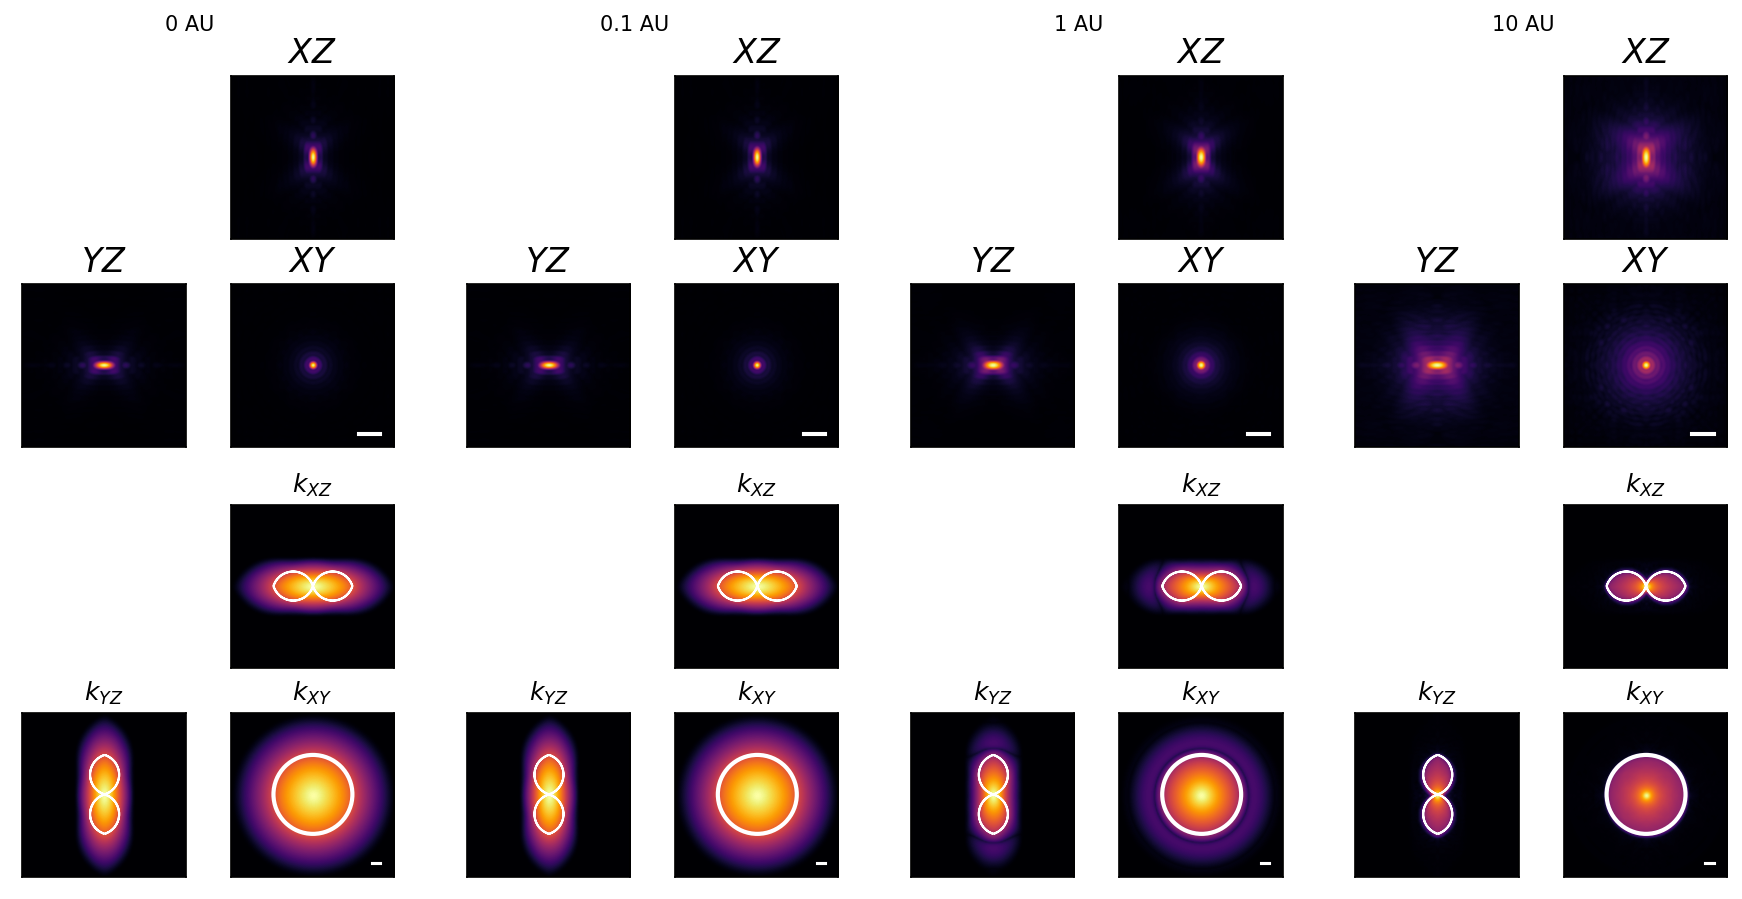

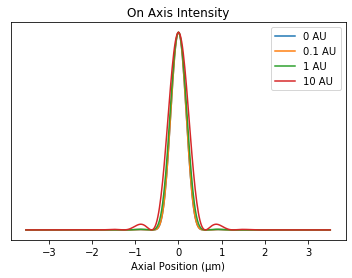

In [13]:
easy_plot([psf_con] + psf_au, ["0 AU"] + label_au, psf_params)

## Spinning Disk Confocal

This should be the same as the point scanning confocal except the detection PSF needs to be convolved with _both_ the pinhole _and_ the camera pixel.